# &#x1F310; &nbsp; Code Library, Style, and Links
Version in `PYTHON`:

&#x1F4D8; &nbsp; [kaggle_passnyc2.ipynb](https://github.com/OlgaBelitskaya/kaggle_notebooks/blob/master/kaggle_passnyc.ipynb)

The previous notebook:

&#x1F4D8; &nbsp; [kaggle_passnyc_R.ipynb](https://github.com/OlgaBelitskaya/kaggle_notebooks/blob/master/kaggle_passnyc_R.ipynb)

Useful `LINKS`:

&#x1F4E1; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

&#x1F4E1; &nbsp; [New York City Department of Education](https://www.schools.nyc.gov)

&#x1F4E1; &nbsp; [NYC OpenData](https://opendata.cityofnewyork.us/)

&#x1F4E1; &nbsp; [ggplot2](https://ggplot2.tidyverse.org/)

&#x1F4E1; &nbsp; [R Tutorial](https://www.tutorialspoint.com/r/index.htm)

In [14]:
library(IRdisplay)
library(repr)
library(tidyverse)
library(formattable)
library(zoo)
library(grid)
library(gridExtra)
library(sf)

#library(tensorflow)
#library(keras)
#library(imager)
#library(R6)
#library(colormap)
#library(purrr)
#library(DT)

In [2]:
#keras_backend <- backend()

In [15]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 5px 5px 5px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}
</style>")

In [16]:
b <- "#3636ff"
r <- "#ff3636"
lr <- "#ff6f6f"
lb <- "#6f6fff"

## &#x1F310; &nbsp; Load and Preprocess the Data

In [17]:
school_explorer <- read.csv("2016 School Explorer.csv")
d5_shsat <- read.csv("D5 SHSAT Registrations and Testers.csv")

In [18]:
dim(school_explorer); dim(d5_shsat)
cat(colnames(school_explorer)[1:38],sep=", ")

[1] 1272  161

[1] 140   7

Adjusted.Grade, New., Other.Location.Code.in.LCGMS, School.Name, SED.Code, Location.Code, District, Latitude, Longitude, Address..Full., City, Zip, Grades, Grade.Low, Grade.High, Community.School., Economic.Need.Index, School.Income.Estimate, Percent.ELL, Percent.Asian, Percent.Black, Percent.Hispanic, Percent.Black...Hispanic, Percent.White, Student.Attendance.Rate, Percent.of.Students.Chronically.Absent, Rigorous.Instruction.., Rigorous.Instruction.Rating, Collaborative.Teachers.., Collaborative.Teachers.Rating, Supportive.Environment.., Supportive.Environment.Rating, Effective.School.Leadership.., Effective.School.Leadership.Rating, Strong.Family.Community.Ties.., Strong.Family.Community.Ties.Rating, Trust.., Trust.Rating

In [19]:
school_explorer <- school_explorer[,4:161]

school_explorer[school_explorer == "N/A"] <- NA

school_explorer$School.Name <- as.character(school_explorer$School.Name)
school_explorer$School.Name[c(428,1024,713,909)] <- 
c('P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27')

school_explorer$School.Income.Estimate <- as.character(school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- sub("\\$","",school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- sub(",","",school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- as.numeric(school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- na.approx(school_explorer$School.Income.Estimate)

percent_list <- c('Percent.ELL',
                  'Percent.Asian','Percent.Black','Percent.Hispanic',
                  'Percent.Black...Hispanic','Percent.White',
                  'Student.Attendance.Rate',
                  'Percent.of.Students.Chronically.Absent',
                  'Rigorous.Instruction..','Collaborative.Teachers..',
                  'Supportive.Environment..','Effective.School.Leadership..',
                  'Strong.Family.Community.Ties..','Trust..')
target_list <- c("Average.ELA.Proficiency","Average.Math.Proficiency")
economic_list <- c("Economic.Need.Index","School.Income.Estimate")
rating_list <- c('Rigorous.Instruction.Rating','Collaborative.Teachers.Rating',
                 'Supportive.Environment.Rating','Effective.School.Leadership.Rating',
                 'Strong.Family.Community.Ties.Rating','Trust.Rating',
                 'Student.Achievement.Rating')

nastr2num <- function(x){ x <- as.numeric(sub("%","",x))}

for (el in c(percent_list,target_list,"Economic.Need.Index")) {
    school_explorer[el] <- sapply(school_explorer[el],nastr2num)
    school_explorer[el] <- na.approx(school_explorer[el])
}

for (el in rating_list) {
    vtable <- data.frame(table(school_explorer[el]))
    mvalue <- as.character(vtable$Var1[vtable$Freq == max(vtable$Freq)])
    school_explorer[el][is.na(school_explorer[el])] <- mvalue
}

In [20]:
sum(is.na(school_explorer))

[1] 0

In [89]:
districts <- data.frame(
    aggregate(. ~ District, 
              school_explorer[c('District',target_list,economic_list)], 
              mean))
dim(districts)

[1] 32  5

In [ ]:
#rep(districts, each=2)

In [168]:
geo_districts <- sf::st_read("nysd.shp")
geo_districts$centroid <- st_centroid(geo_districts$geometry)
geo_districts <- st_transform(geo_districts,crs=4326)
geo_districts$centroid <- st_transform(geo_districts$centroid,crs=4326)
geo_districts <- data.frame(geo_districts)
geo_districts <- geo_districts[order(geo_districts$SchoolDist),]
rownames(geo_districts) <- c(1:33)

Reading layer `nysd' from data source `/Users/olgabelitskaya/kaggle_notebooks/nysd.shp' using driver `ESRI Shapefile'
Simple feature collection with 33 features and 3 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 913175.1 ymin: 120121.9 xmax: 1067383 ymax: 272844.3
epsg (SRID):    NA
proj4string:    +proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +datum=NAD83 +units=us-ft +no_defs


In [239]:
coords <- do.call(rbind, st_geometry(geo_districts$centroid)) %>% 
              as_tibble() %>% 
              setNames(c("lon","lat"))
geo_districts[c('lon','lat')] <- coords

In [240]:
head(geo_districts,11)

SchoolDist,Shape_Leng,Shape_Area,geometry,centroid,lon,lat
1,28641.276,35160748,MULTIPOLYGON (((-73.97177 4...,POINT (-73.98273 40.72144),-73.98273,40.72144
2,214498.703,280467718,MULTIPOLYGON (((-74.04388 4...,POINT (-73.98643 40.74434),-73.98643,40.74434
3,52072.051,113488883,MULTIPOLYGON (((-73.95672 4...,POINT (-73.96902 40.789),-73.96902,40.78900
4,52061.828,52620428,MULTIPOLYGON (((-73.92134 4...,POINT (-73.93381 40.79263),-73.93381,40.79263
5,44469.588,52519774,MULTIPOLYGON (((-73.93516 4...,POINT (-73.94444 40.81471),-73.94444,40.81471
6,70447.849,96341704,MULTIPOLYGON (((-73.92641 4...,POINT (-73.93495 40.84956),-73.93495,40.84956
7,65294.452,92262468,MULTIPOLYGON (((-73.89681 4...,POINT (-73.91105 40.80878),-73.91105,40.80878
8,223080.143,258826603,MULTIPOLYGON (((-73.83979 4...,POINT (-73.85011 40.8224),-73.85011,40.82240
9,46648.959,83415392,MULTIPOLYGON (((-73.9213 40...,POINT (-73.91352 40.83897),-73.91352,40.83897
10,94957.571,282541462,MULTIPOLYGON (((-73.8679 40...,POINT (-73.89331 40.8796),-73.89331,40.87960


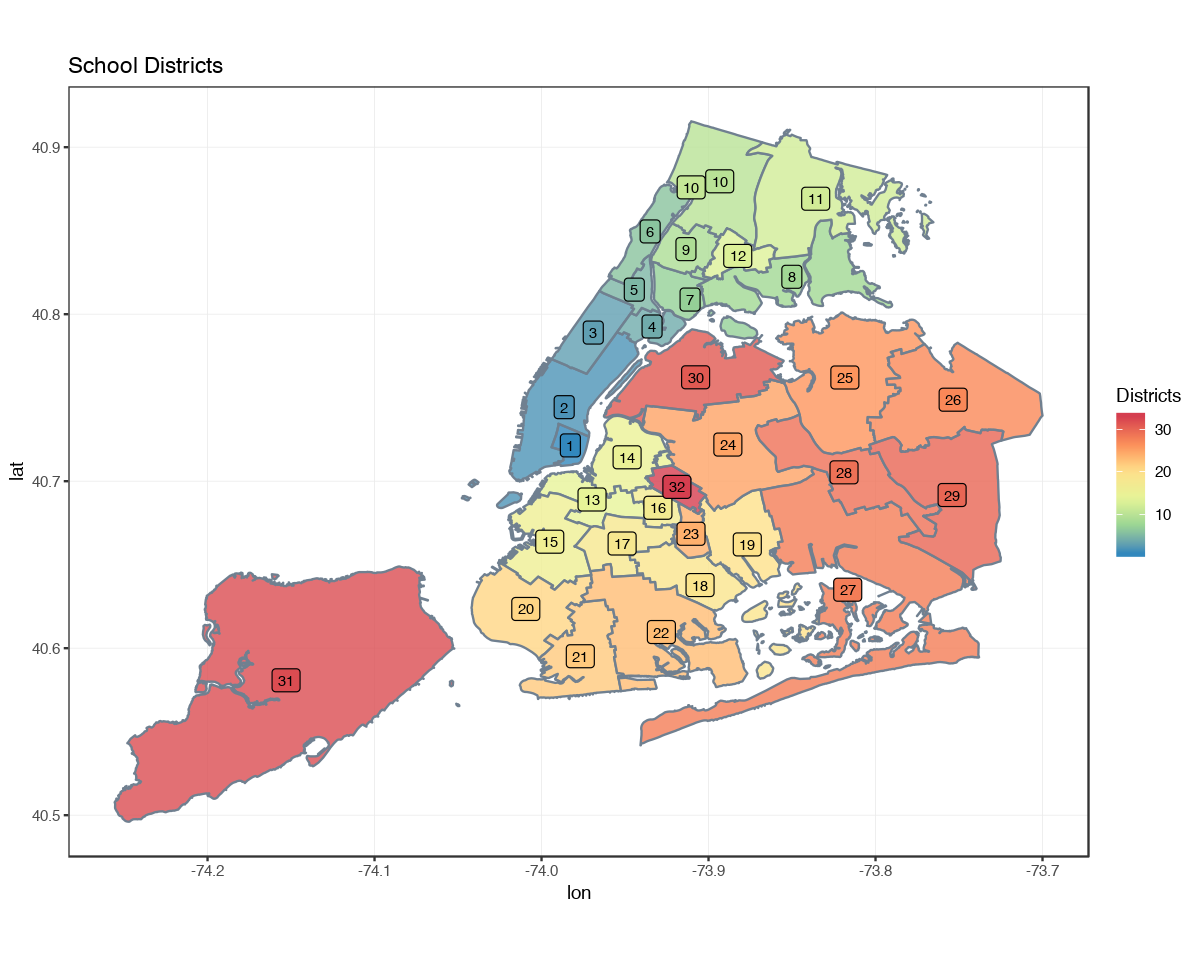

In [257]:
options(repr.plot.width=10,repr.plot.height=8)
ggplot(geo_districts,aes(fill=c(1:33))) + 
    geom_sf(data=geo_districts,size=0.5,
            color="slategray",alpha=0.8) + 
    geom_label(aes(x=lon,y=lat,label=SchoolDist),size=3) +
    scale_fill_distiller(name="Districts",palette = "Spectral") +
    ggtitle("School Districts") + theme_bw()

## &#x1F310; &nbsp; Classification of Variables